In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder# instantiate labelencoder object
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [12]:
#Load data

data_path = './malicious-connection-dataset';
train_bad_data_path = './malicious-connection-dataset/df_bad.csv';
train_good_data_path = './malicious-connection-dataset/df_good.csv';
classify_data_path = './malicious-connection-dataset/df_good.csv';

class SimpleLoader:
    
    def __init__ (self, is_training_session = True):
        self._is_training_session = is_training_session
    
    def load(self, data_path = '',
                train_bad_data_path = '',
                train_good_data_path = '',
                classify_data_path = ''):
        
        for dirname, _, filenames in os.walk(data_path):
            for filename in filenames:
                os.path.join(dirname, filename)
                
        df = None
        if(self._is_training_session):
            df_bad = pd.read_csv(train_bad_data_path, encoding='ISO-8859-2')
            df_bad.rename(columns={'Unnamed: 0':'unnamed'}, inplace=True)
            df_bad.drop('unnamed', axis=1, inplace=True)
            df_bad.insert(0, 'label', 0)

            df_good = pd.read_csv(train_good_data_path, encoding='ISO-8859-2')  
            df_good.rename(columns={'Unnamed: 0':'unnamed'}, inplace=True)
            df_good.drop('unnamed', axis=1, inplace=True)
            df_good.insert(0, 'label', 1)
            df = pd.concat([df_good, df_bad], ignore_index=True)
        else:
            df = pd.read_csv(classify_data_path, encoding='ISO-8859-2')
            df.rename(columns={'Unnamed: 0':'unnamed'}, inplace=True)
            df.drop('unnamed', axis=1, inplace=True)
        return df

    
#train_loader = SimpleLoader(True)
#df = train_loader.load(data_path=data_path, 
                  train_bad_data_path=train_bad_data_path, 
                  train_good_data_path = train_good_data_path)

#classify_loader = SimpleLoader(False)
#df_classify = classify_loader.load(classify_data_path=classify_data_path)

IndentationError: unexpected indent (<ipython-input-12-beaf8c955a58>, line 43)

In [13]:
class SimplePreProcessor:
    def __init__ (self, is_training_session = True):
        self._is_training_session = is_training_session
    
    def preprocess_all(self, df):
        df = self.convert_time(self.convert_numericals(df))
        if self._is_training_session:
            df = self.encode_categorical(df)
        df = normalize_features(df)
        return df
        
    def encode_categorical(self, df):
        cols = ['ip', 'port']
        le = LabelEncoder()
        df[cols] = df[cols].apply(lambda col: le.fit_transform(col))
        return df
    
    def normalize_features(self, df):
        cols = ['times', 'di', 'do', 'pi', 'po', 'ip', 'port']
        df[cols] = (df[cols]-df[cols].mean())/df[cols].std()
        return df

    def convert_time(self, df):
        df[['times']] = df[['times']].apply(self._time_converter, axis=0)
        return df
    
    def convert_numericals(self, df):
        df[['di']] = df[['di']].apply(self._num_converter, axis=0)
        df[['do']] = df[['do']].apply(self._num_converter, axis=0)
        df[['pi']] = df[['pi']].apply(self._num_converter, axis=0)
        df[['po']] = df[['po']].apply(self._num_converter, axis=0)
        return df
        
    def _num_converter(self, s):
        s = s.fillna(0).astype(str).str.split(",", expand = False).apply(
                lambda x : [int(y) for y in x]
            )
        s = s.apply(lambda x : np.std(x))
        return s
        
    def _time_converter(self, s):
        s = s.fillna(0).astype(str).str.split("|", expand = False).apply(
                lambda x : [[int(i) for i in y.split(',')] for y in x]
            )
        s = s.apply(lambda x : np.std(np.concatenate(x)))
        return s

#train_processor = SimplePreProcessor(True)
#test_processor = SimplePreProcessor(False)

#df = train_processor.preprocess_all(df)
#df_classify = classify_processor.preprocess_all(df_classify)

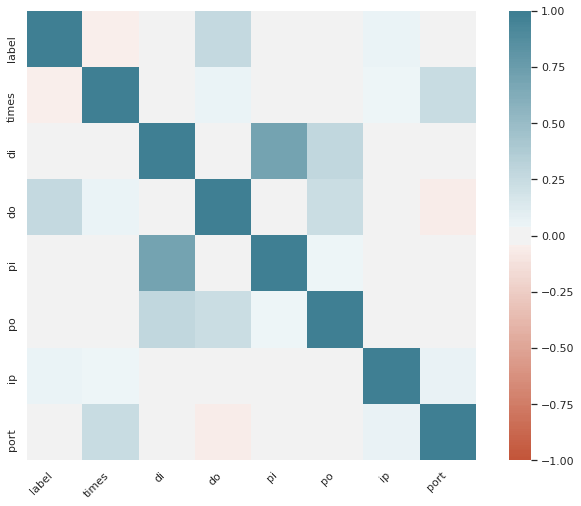

In [14]:
#Plot corellation
cols = ['label', 'times', 'di', 'do', 'pi', 'po', 'ip', 'port']
corr = df[cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [15]:
class SimpleModel():
    def __init__ (self):
        self._feature_selector_model = None
        self._classifier_model = None
        
    def train(self, df):
        model, X_train, X_test, X_train, X_test, y_train, y_test = self._selective_train_test_split(df);
        self._feature_selector_model = model
        param_grid = {
        'bootstrap': [True],
        'max_depth': [2, 20, 40],
        'max_features': [1, 3, 7],
        'min_samples_leaf': [2, 4, 8],
        'min_samples_split': [5, 10, 10],
        'n_estimators': [5, 25, 50]
        }
        rf = RandomForestClassifier()
        clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                  cv = 3, n_jobs = -1, verbose = 2)


        clf.fit(X_train, y_train)
        y_pred = (clf.predict(X_test))
        target_names = ['good', 'bad']
        self._classifier_model = clf
        
        return (classification_report(y_test, y_pred, target_names=target_names),
                accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred))

        
        
    def classify(self, df):
        if self._feature_selector_model is None or self._classifier_model is None:
            raise('Model appears to be untrained.')
            
        X = self._feature_selector_model.transform(df[['ip', 'port', 'times', 'di', 'do', 'pi', 'po']])
        y_pred = self._self._classifier_model.predict(X)
        return y_pred
        
        
        
        
    def _selective_train_test_split(self, df):
        #Train Test split
        #Feature selection via cheap classifier
        X = df[['ip', 'port', 'times', 'di', 'do', 'pi', 'po']]
        y = df[['label']]

        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

        #Feature selection via cheap classifier
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(X_train, y_train)

        model = SelectFromModel(clf, prefit=True, threshold='0.5*mean')
        X_train = model.transform(X_train)
        X_test = model.transform(X_test)
        return model, X_train, X_test, X_train, X_test, y_train, y_test

#simple_model = SimpleModel()
#simple_model.train(df)

In [ ]:
class SimplePipeline:
    def __init__(self):
        self._train_loader = SimpleLoader(True)
        self._classify_loader = SimpleLoader(False)
        self._train_processor = SimplePreProcessor(True)
        self._test_processor = SimplePreProcessor(False)
        self._simple_model = SimpleModel()

    def fit_csv(self, data_path, train_bad_data_path, train_good_data_path):
        df = self._train_loader.load(data_path=data_path, 
                  train_bad_data_path=train_bad_data_path, 
                  train_good_data_path = train_good_data_path)
        df = train_processor.preprocess_all(df)
        simple_model = SimpleModel()
        return simple_model.train(df)


    def predict_csv(self, data_path, classify_data_path):
        df = self._classify_loader.load(classify_data_path=classify_data_path)
        df = self._classify_processor.preprocess_all(df)
        return simple_model.classify(df)

    def predict_df(self, df):
        df = self._classify_processor.preprocess_all(df)
        return simple_model.classify(df)

data_path = './malicious-connection-dataset';
train_bad_data_path = './malicious-connection-dataset/df_bad.csv';
train_good_data_path = './malicious-connection-dataset/df_good.csv';
classify_data_path = './malicious-connection-dataset/df_good.csv';

simple_pipeline = SimplePipeline()
report, accuracy, confusion = simple_pipeline.fit_csv(data_path, train_bad_data_path, train_good_data_path)
y_pred = simple_pipeline.predict_csv(data_path, classify_data_path)

In [ ]:
X_pred_bad = X_test[np.where(y_pred == 1)]
X_pred_good = X_test[np.where(y_pred == 0)]

from sklearn.cluster import OPTICS
clustering = OPTICS(min_samples=2).fit(X_pred_bad)


In [ ]:
print(len(set(clustering.labels_)))